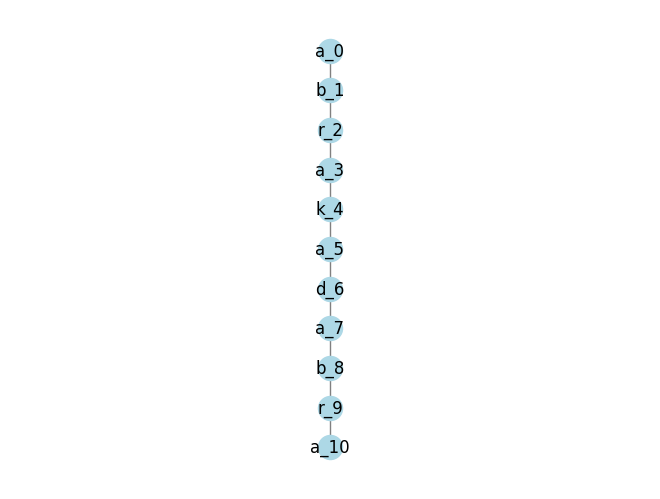

In [45]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

example_string = "abrakadabra"
example_array = list(example_string)

example_array_indexed = [f"{example_array[i]}_{i}" for i in range(len(example_array))]

# Add nodes
for node in example_array_indexed:
    G.add_node(node)

# Connect nodes sequentially
for i in range(len(example_array_indexed) - 1):
    G.add_edge(example_array_indexed[i], example_array_indexed[i+1])

pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

Find Adj matrix

In [46]:
def relabel_string(string):
    # Convert the string to a set of unique characters
    unique_chars = set(string)

    # Count the number of elements in the set
    n = len(unique_chars)

    # Create a dictionary to map each character to its new label
    label_mapping = {char: (i+1) * (1/(n+1)) for i, char in enumerate(unique_chars)}

    # Relabel the characters in the string based on the mapping
    relabeled_string = [label_mapping[char] for char in string]

    return relabeled_string

relabeling = relabel_string(example_string)
labels_G1 = np.diag(relabeling)
G_adj = nx.to_numpy_array(G)

G_adj_relabel = G_adj + labels_G1

print(G_adj_relabel)

[[0.33333333 1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [1.         0.66666667 1.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         1.         0.5        1.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.33333333 1.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.83333333 1.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.33333333
  1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.16666667 1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.33333333 1.         0.         0.        ]
 [0.         0.         0.         0.         0.

In [47]:
def floyd_warshall_with_path_reconstruction(adj_matrix):
    n = len(adj_matrix)
    dist_matrix = np.copy(adj_matrix)
    next_node = np.zeros(adj_matrix.shape, dtype=int)

    # Initialize distance and next matrices
    for i in range(n):
        for j in range(n):
            if i != j and adj_matrix[i][j] == 0:
                dist_matrix[i][j] = np.inf
            else:
                next_node[i][j] = j

    # Floyd-Warshall with path reconstruction
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if dist_matrix[i][k] + dist_matrix[k][j] < dist_matrix[i][j]:
                    dist_matrix[i][j] = dist_matrix[i][k] + dist_matrix[k][j]
                    next_node[i][j] = next_node[i][k]

    return dist_matrix, next_node

def reconstruct_path(start, end, next_node):
    if next_node[start][end] == 0:
        return []

    path = [start]
    while start != end:
        start = next_node[start][end]
        path.append(start)

    return path

dist_matrix, next_node_matrix = floyd_warshall_with_path_reconstruction(G_adj_relabel)

dist_matrix[dist_matrix == np.inf] = -1

# Find the maximum distance and corresponding node pair
max_distance = np.max(dist_matrix)
furthest_nodes = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)


# Reconstructing the path between the furthest nodes
path = reconstruct_path(furthest_nodes[0], furthest_nodes[1], next_node_matrix)
# print(path)

def find_non_overlapping_subarrays(arr, n):
    subarrays = []
    length = len(arr)

    # Iterate over the array to create subarrays
    for i in range(length - n + 1):
        for j in range(i + n, length - n + 1):
            subarrays.append((arr[i:i+n], arr[j:j+n]))

    return subarrays

# given a matrix and indices, give the submatrix
def submatrix(matrix, indices):
    return matrix[np.ix_(indices, indices)]

def spectrum(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.sort(eigenvalues)

def compare_spectra(spectrum1, spectrum2):
    return np.allclose(spectrum1, spectrum2, rtol=0.00001)

def find_subunits(adjecency_matrix, path):
    # Starting from n = len(path) // 2 and going down to 1 using a for loop
    # get the submatrices of the adjecency matrix using the subarrays and compare their spectra
    # if the spectra are the same, return the subarrays

    for n in range(len(path) // 2, 0, -1):
        subarrays = find_non_overlapping_subarrays(path, n)
        for subarray in subarrays:
            submatrix1 = submatrix(adjecency_matrix, subarray[0])
            submatrix2 = submatrix(adjecency_matrix, subarray[1])

            spectrum1 = spectrum(submatrix1)
            spectrum2 = spectrum(submatrix2)

            if compare_spectra(spectrum1, spectrum2):
                return subarray
            
subs = find_subunits(G_adj_relabel, path)
print(subs)


([0, 1, 2, 3], [7, 8, 9, 10])
